Build training, validation and testing datasets

In [1]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time

Retrieve all file names

In [2]:
data_path = '../handmadeGenre'
genre_path_dict = dict()
label_dict = dict()

for (dirpath, dirnames, filenames) in os.walk(data_path):
    if dirnames:
        for idx, genre in enumerate(dirnames):
            genre_path_dict[genre] = list()
            label_dict[genre] = idx
        continue
    else:
        genre = dirpath.split('/')[-1]
        for au_file in filenames:
            if 'mp3' in au_file:
                current_path = dirpath + '/' + au_file
                genre_path_dict[genre].append(current_path)

total_file = sum([len(genre_path_dict[genre]) for genre in genre_path_dict])
total_file

72

Create log-Mel spectrogram

In [3]:
# global varibles:
sr = 16000
cut_time = 10  # throw first and last 10s
cut_wave_length = cut_time * sr
n_ftt = 512
hop = n_ftt // 4

In [4]:
label_dict

{'pop': 0,
 'metal': 1,
 'disco': 2,
 'blues': 3,
 'reggae': 4,
 'classical': 5,
 'rock': 6,
 'hiphop': 7,
 'country': 8,
 'jazz': 9}

In [5]:
genre_dict = dict()
for key in label_dict:
    genre_dict[label_dict.get(key)] = key

In [6]:
genre_dict

{0: 'pop',
 1: 'metal',
 2: 'disco',
 3: 'blues',
 4: 'reggae',
 5: 'classical',
 6: 'rock',
 7: 'hiphop',
 8: 'country',
 9: 'jazz'}

In [7]:
genre_path_dict['pop'][0]

'../handmadeGenre/pop/EGOIST - All Alone With You.mp3'

In [8]:
# This is the newer one
def frame_feature_extractor(file_path):
    signal, _ = librosa.load(file_path, sr=sr)
    signal = signal[cut_wave_length: -1 * cut_wave_length] # cut wave length
    
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=256).T
    S = librosa.power_to_db(S)
    if not S.shape[0] % 256 == 0:
        S = S[:-1 * (S.shape[0] % 256)] # divide the mel spectrogram
    chunk_num = int(S.shape[0] / 256)
    mel_chunks = np.split(S, chunk_num) # create 128 * 128 data frames
    return mel_chunks, chunk_num

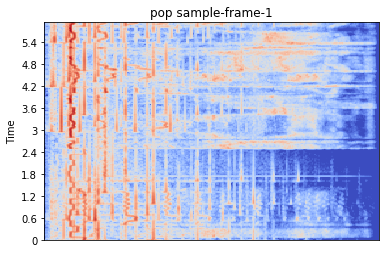

In [9]:
signal, chunk_num = frame_feature_extractor(genre_path_dict['pop'][0])
plt.title('pop sample-frame-1')
display.specshow(signal[0], y_axis='time')
plt.show()

## Build datasets

In [10]:
def build_tag(genre):
    target = np.zeros(len(label_dict), dtype=int)
    pos = label_dict.get(genre)
    target[pos] = 1
    return target

build_tag('pop').shape

(10,)

## Create separate dataset for each file

In [11]:
data_set_path = '../handmadeDBL/'

In [12]:
count = 0
file_index = 0
mel_shape = signal[0].shape

for key in label_dict:
    print('deal with {0}'.format(key))
    for file_i, file in enumerate(genre_path_dict.get(key)):
        mel_list, chunk_number = frame_feature_extractor(file)
        dataset_name = data_set_path + str(file_index) + '.h5'
        current_dataset = h5py.File(dataset_name, 'a')
        
        current_dataset.create_dataset('mel', shape=(chunk_number, mel_shape[0], mel_shape[1]), dtype=np.float32)
        current_dataset.create_dataset('tag', shape=(chunk_number, 10 ), dtype=int)   
        
        for i, mel_signal_chunk in enumerate(mel_list):
            current_dataset['tag'][i] = build_tag(key)
            current_dataset['mel'][i] = mel_signal_chunk
            count += 1
        
        print('->{0}'.format(file_i), end='')
        current_dataset.close()
        file_index += 1
        
    print(' ')

print(count)
print(file_index)
    

deal with pop
->0->1->2->3->4->5->6->7 
deal with metal
->0->1->2->3->4->5->6 
deal with disco
->0->1->2->3->4->5->6->7 
deal with blues
->0->1->2->3->4->5->6->7->8->9 
deal with reggae
->0->1->2->3->4->5->6->7 
deal with classical
->0->1->2->3->4 
deal with rock
->0->1->2->3->4->5->6 
deal with hiphop
->0->1->2->3 
deal with country
->0->1->2->3->4->5->6->7 
deal with jazz
->0->1->2->3->4->5->6 
2667
72


In [13]:
all_setpath = data_set_path + 'hand_all.h5'
all_dataset = h5py.File(all_setpath, 'a')

In [14]:
all_dataset.create_dataset('mel', shape=(count, mel_shape[0], mel_shape[1]), dtype=np.float32)
all_dataset.create_dataset('tag', shape=(count, 10 ), dtype=int)   

<HDF5 dataset "tag": shape (2667, 10), type "<i8">

### load data in one set

In [15]:
count = 0
for (dirpath, dirnames, filenames) in os.walk(data_set_path):
    if filenames:
        for set_name in filenames:
            if 'h5' not in set_name or 'all' in set_name:
                continue
            set_path = data_set_path + set_name
            tmp_dataset = h5py.File(set_path, 'r')
            tmp_count = tmp_dataset['mel'].shape[0]
            for i in range(tmp_count):
                all_dataset['mel'][count] = tmp_dataset['mel'][i]
                all_dataset['tag'][count] = tmp_dataset['tag'][i]
                count += 1
            tmp_dataset.close()
all_dataset.close()
print(count)

2667


In [16]:
setpath1 = data_set_path + 'hand_all.h5'
setpath2 = '../datasets/all_long.h5'
db1 = h5py.File(setpath1, 'r')
db2 = h5py.File(setpath2, 'r')
all_chunk = count + 3000

fin_setpath = data_set_path + 'fin_all.h5'
dataset = h5py.File(fin_setpath, 'a')
dataset.create_dataset('mel', shape=(all_chunk, mel_shape[0], mel_shape[1]), dtype=np.float32)
dataset.create_dataset('tag', shape=(all_chunk, 10 ), dtype=int) 

fin_count = 0
for j in range(count):
    dataset['mel'][fin_count] = db1['mel'][j]
    dataset['tag'][fin_count] = db1['tag'][j]
    fin_count += 1

db1.close()

for j in range(3000):
    dataset['mel'][fin_count] = db2['mel'][j]
    dataset['tag'][fin_count] = db2['tag'][j]
    fin_count += 1

db2.close()
dataset.close()
print(fin_count)

5667


## Build Separate Datasets

In [17]:
import random

In [18]:
dataset = h5py.File(fin_setpath, 'r')

In [23]:
train_file = fin_count * 0.8
valid_file = fin_count * 0.1
test_file = fin_count - int(train_file) - int(valid_file)

In [24]:
train_set = '../datasets/l_train.h5'
valid_set = '../datasets/l_valid.h5'
test_set = '../datasets/l_test.h5'

In [25]:
files = [int(a) for a in [train_file, valid_file, test_file]]
sets = [train_set, valid_set, test_set]
print(files)

[4533, 566, 568]


### Shuffle and create

In [26]:
idx = [i for i in range(fin_count)]
random.seed(516)
random.shuffle(idx)

In [27]:
train_idx = idx[:files[0]]
valid_idx = idx[files[0]: files[0]+files[1]]
test_idx = idx[-files[2]:]
indices = [train_idx, valid_idx, test_idx]

### Copy

In [28]:
for i, dset in enumerate(sets):
    s_set = h5py.File(dset, 'a')
    indice = indices[i]
    file_num = files[i]
    
    s_set.create_dataset('mel', shape=(file_num, mel_shape[0], mel_shape[1]), dtype=np.float32)
#     s_set.create_dataset('mfcc', shape=(file_num, mfcc_shape[0], mfcc_shape[1]), dtype=np.float32)
    s_set.create_dataset('tag', shape=(file_num, 10 ), dtype=int)
    
    count = 0
    for i in indice:
        s_set['mel'][count] = dataset['mel'][i]
#         s_set['mfcc'][count] = dataset['mfcc'][i]
        s_set['tag'][count] = dataset['tag'][i]
        count += 1
        
        if count % 10 == 0:
            print('*', end="")
    
    s_set.close()
    print()  
    print('Create Separate Datasets {0}'.format(dset))
    

*********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Create Separate Datasets ../datasets/l_train.h5
********************************************************
Create Separate Datasets ../datasets/l_valid.h5
********************************************************
Create Separate Datasets ../datasets/l_test.h5


## Test Here

In [29]:
t_set = h5py.File(train_set, 'r')
mel_shape

(256, 256)

In [30]:
print(t_set['mel'].shape)
print(t_set['tag'][:5])

(4533, 256, 256)
[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
